Say that you have N questions in store. You create M questionnaires (for M pupils for instance) from this pool, each composed of n questions, without repetition of questions and sorting the questions. Then the aim is to compute the probability of have at least twice the same questionnaire.

# Utilities

In [238]:
%pylab inline

import pandas as pd
import string
import scipy
import datetime as dt
from contextlib import contextmanager
import matplotlib.colors as mcolors

plt.style.use('big_plt_style.mplstyle')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/earendil/.virtualenvs/data-analysis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [220]:
@contextmanager
def clock_time(message_before=None, 
	message_after='executed in', print_function=print,
	oneline=False):

	if message_before is not None:
		if oneline:
			print_function(message_before, end="\r")
		else:
			print_function(message_before)
	start = dt.datetime.now()
	yield
	elapsed = dt.datetime.now() - start

	if oneline and message_before is not None:
		message = ' '.join([message_before, message_after, str(elapsed)])
	else:
		message = ' '.join([message_after, str(elapsed)])
		
	print_function (message)
    
def simple_color_map_function(color1, color2, min_value=0., max_value=1.):
	"""
	Build a function for simple linear interpolation between two colors.
	"""
	if type(color1) in [str]:
		color1 = hex_to_rgb(color1)
	if type(color2) in [str]:
		color2 = hex_to_rgb(color2)

	def f(value):
		norm_value = (float(max_value)-float(value))/(float(max_value)-float(min_value))
		avg = np.average(np.array([color1, color2]), axis=0, weights=[norm_value, 1. - norm_value])
		return np.clip(avg, 0., 1.)
	return f

def simple_colormap_object(cmap_f, min_value=0., max_value=1., k=100):
	"""
	This is designed to used in conjunction with the above function

	To make the color map legend, do:
	cbar = fig.colorbar(sm, ax=ax)
	cbar.ax.set_ylabel('Statistical significance')
	"""
	cmap, norm = mcolors.from_levels_and_colors(linspace(min_value, max_value, k+1),
												[cmap_f(hue) for hue in linspace(min_value, max_value, k)])
	sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])

	return sm

def hex_to_rgb(value):
	value = value.lstrip('#')
	lv = len(value)
	rgb_255 = tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))
	return tuple(a/255. for a in rgb_255)

nice_colors = ['#348ABD',  '#7A68A6',  '#A60628',  '#467821',  '#CF4457',  '#188487',  '#E24A33']
nice_colors = [hex_to_rgb(v) for v in nice_colors]

# Theory

In [108]:
# Number of questionnaire possible when selecting n questions among N.
# Questions cannot be duplicated, and their order do not matter.
def S(n, N):
    return math.comb(N, n)

# Given number of possible questionnaires SS and number of questionnaires to produce, compute
# proba of having all questionnaires different and take the negative.
def P_th(SS, M):
    if SS>=M:
        return 1.- math.factorial(SS)/(math.factorial(SS-M)*SS**M)
    else:
        return 1.

def p_exact(n, N, M):
    return P_th(S(n, N), M)
    
    
p_exact(3, 6, 10)

0.9345270925

In [151]:
# Faster

def S_fast(n, N):
    return int(scipy.special.comb(N, n))

def P_th_fast(SS, M):
    if SS>=M:
        return 1.- scipy.special.factorial(SS)/(scipy.special.factorial(SS-M)*SS**M)
    else:
        return 1.

def p_exact_fast(n, N, M):
    return P_th_fast(S_fast(n, N), M)

p_exact_fast(3, 6, 10)

0.9345270925

In [167]:
# Better, and fast
def stuff2(M, SS, SS_tot):
    if SS==SS_tot-M:
        return 1
    else:
        return stuff2(M, SS-1, SS_tot) * SS

def stuff(M, SS):
    return stuff2(M, SS, SS)
    
def P_th_fastest(SS, M):
    if SS>=M:
        return 1.- stuff(M, SS)/SS**(M)
    else:
        return 1.

def p_exact_fastest(n, N, M):
    return P_th_fastest(S_fast(n, N), M)

p_exact_fastest(3, 6, 10)

0.9345270925

In [189]:
n = 10 # number of questions on one questionnaire
N = 22 # Number of possible questions
M = 20 # number of pupils

#print (S_fast(n, N))

with clock_time(message_after='Done fastest in'):
    print (p_exact_fastest(n, N, M))
print ()
with clock_time(message_after='Done fast in'):
    print (p_exact_fast(n, N, M)) # Faster but not very good....
print ()
with clock_time(message_after='Done standard in'):
    print (p_exact(n, N, M))

0.000293783613898424
Done fastest in 0:00:00.000098

nan
Done fast in 0:00:00.000103



/tmp/ipykernel_17038/1854343285.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return 1.- scipy.special.factorial(SS)/(scipy.special.factorial(SS-M)*SS**M)


0.000293783613898424
Done standard in 0:00:05.741882


# Simulations

In [54]:
# Generate set of copies
def gen_copy(questions, n):
    return tuple(sorted(np.random.choice(questions, size=n, replace=False)))

def gen_copies(questions, n, M):
    return [gen_copy(questions, n) for i in range(M)]

def is_there_at_least_two_identical_copies(copies):
    return len(set(copies))!=len(copies)

# Sample 
def compute_approximate_proba(n_iter, n=7, N=50, M=30):
    results = [is_there_at_least_two_identical_copies(gen_copies(list(range(N)), n, M)) for i in range(n_iter)]
    
    return np.mean(results)

In [168]:
N = 4
M = 4
n = 2
n_iter = 100

print (p_exact_fastest(n, N, M))
print (compute_approximate_proba(n_iter, n=n, N=N, M=M))

0.7222222222222222
0.69


In [169]:
N = 4
M = 4
n = 2
n_iter = 10000

print (p_exact_fastest(n, N, M))
print (compute_approximate_proba(n_iter, n=n, N=N, M=M))

0.7222222222222222
0.7181


In [170]:
N = 10
M = 10
n = 3
n_iter = 10000

print (p_exact_fastest(n, N, M))
print (compute_approximate_proba(n_iter, n=n, N=N, M=M))

0.31975753179568944
0.324


# Plots

In [239]:
n = 3 # number of questions
M = 10 # number of pupils
N_max = 20

p_exact_vec = np.vectorize(lambda x: p_exact_fastest(n, x, M))
xxN = list(range(n, N_max))
results = p_exact_vec(xxN)

Text(0, 0.5, 'Proba. at least 2 identical')

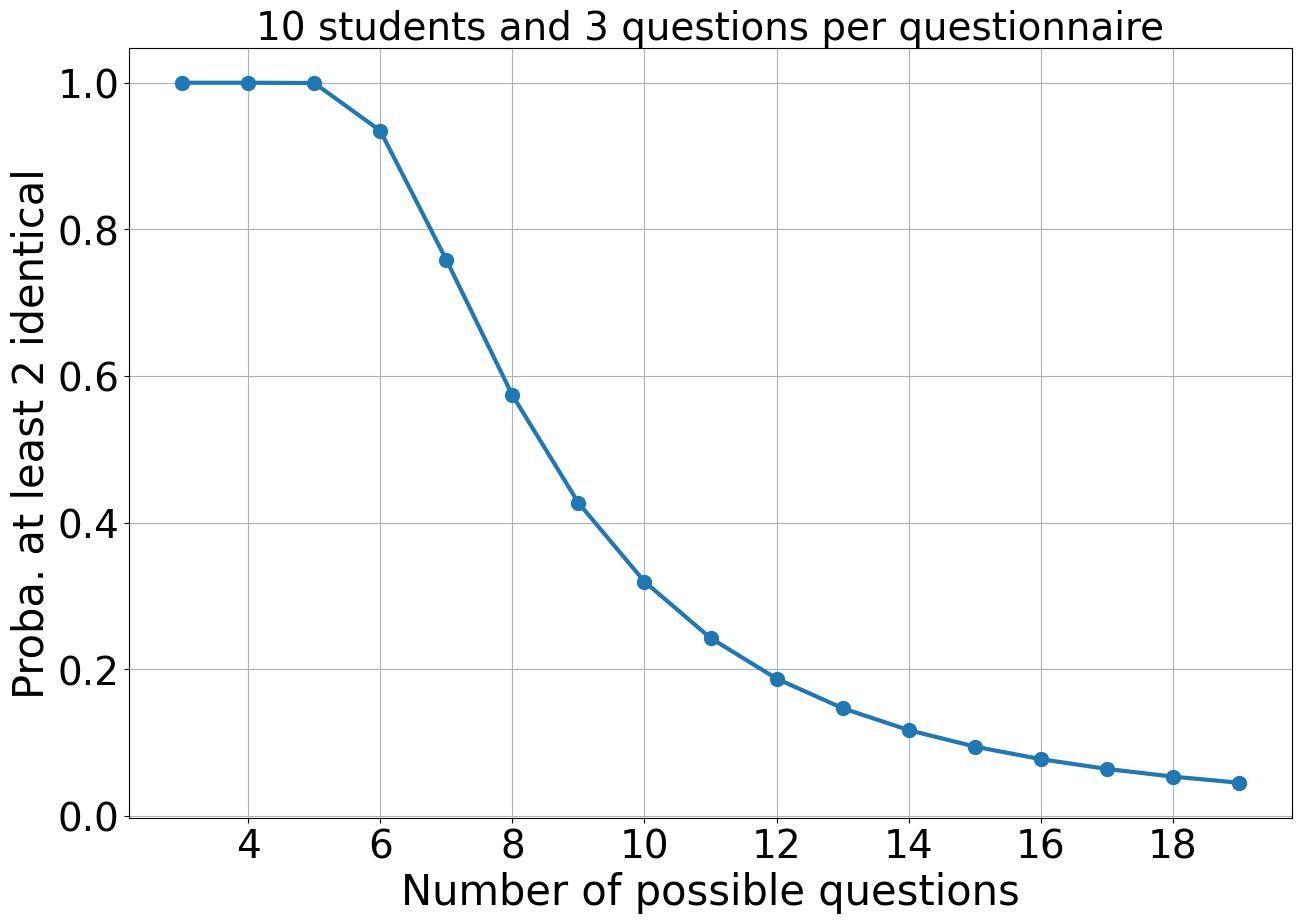

In [240]:
fig, ax = subplots()
ax.plot(xxN, results, 'o-')

ax.set_title('{} students and {} questions per questionnaire'.format(M, n))
ax.set_xlabel('Number of possible questions')
ax.set_ylabel('Proba. at least 2 identical')

In [241]:
n = 10 # number of questions
M = 20 # number of pupils
N_max = 30

p_exact_vec = np.vectorize(lambda x: p_exact_fastest(n, x, M))
xxN = list(range(n, N_max)) # number of possible questions
results = p_exact_vec(xxN)

Text(0, 0.5, 'Proba. at least 2 identical')

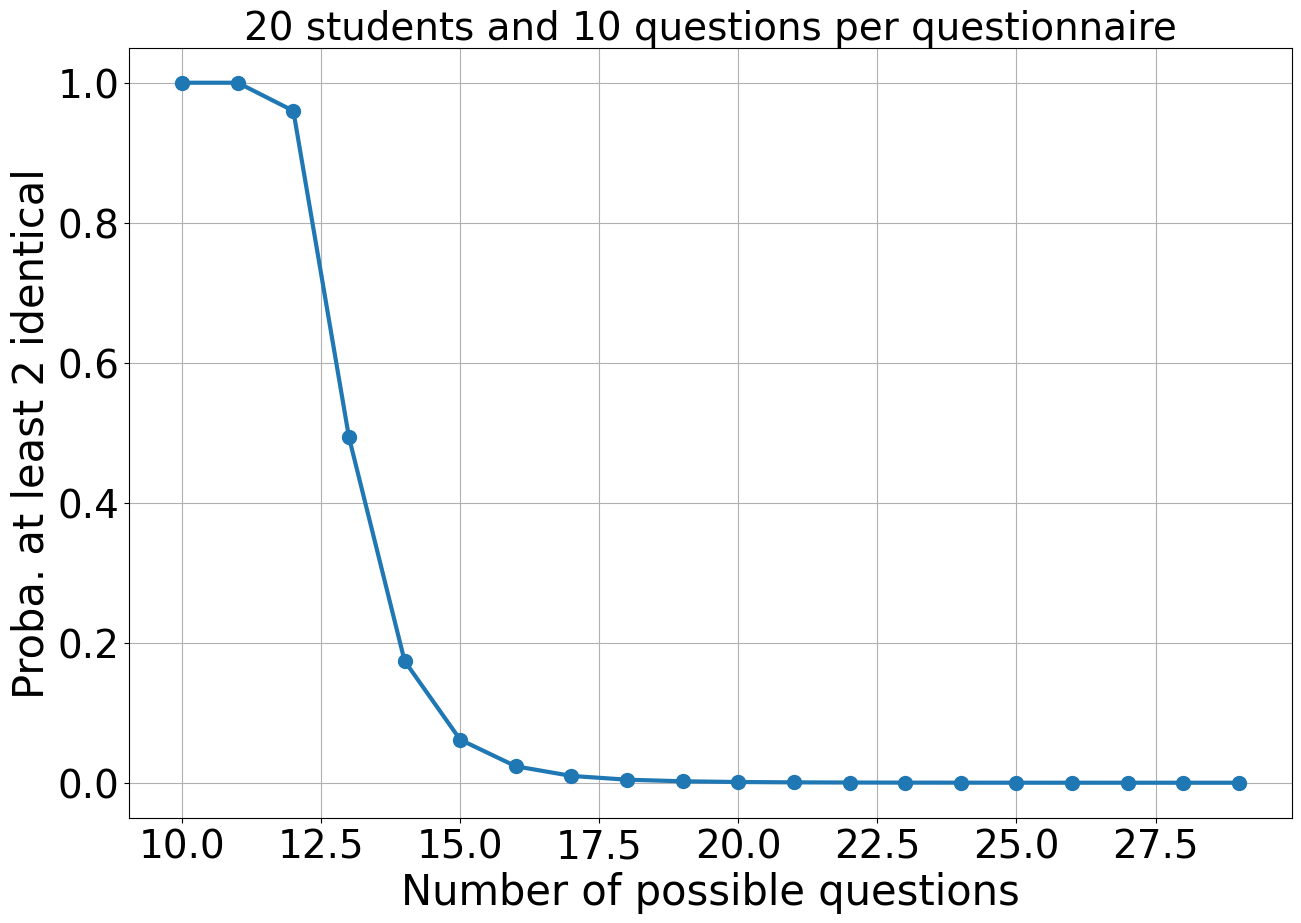

In [242]:
fig, ax = subplots()
ax.plot(xxN, results, 'o-')

ax.set_title('{} students and {} questions per questionnaire'.format(M, n))
ax.set_xlabel('Number of possible questions')
ax.set_ylabel('Proba. at least 2 identical')

In [243]:
n = 10 # number of questions
M = 40 # number of pupils
N_max = 40

p_exact_vec = np.vectorize(lambda x: p_exact_fastest(n, x, M))
xxN = list(range(n, N_max)) # number of possible questions
results = p_exact_vec(xxN)

Text(0, 0.5, 'Proba. at least 2 identical')

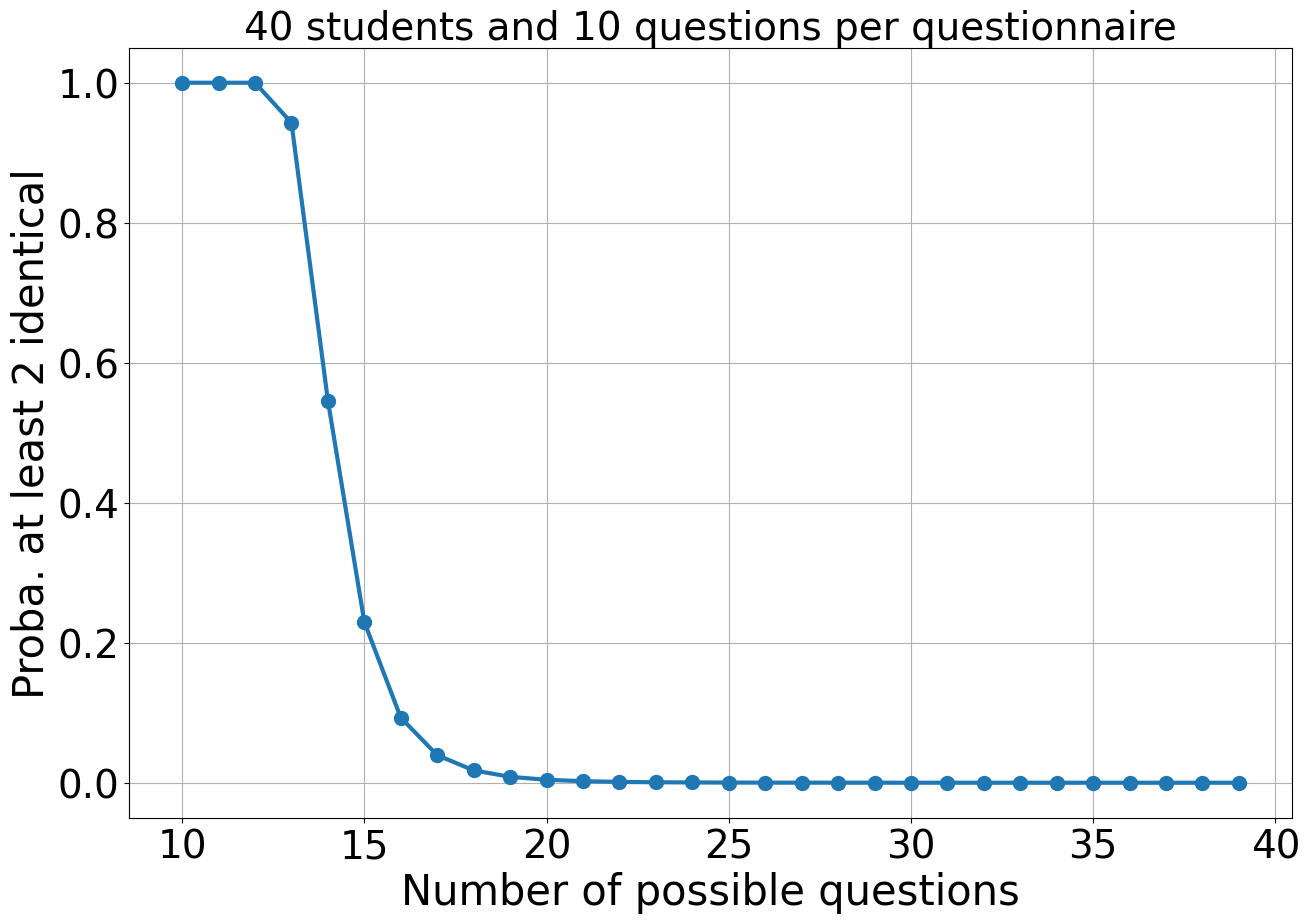

In [244]:
fig, ax = subplots()
ax.plot(xxN, results, 'o-')

ax.set_title('{} students and {} questions per questionnaire'.format(M, n))
ax.set_xlabel('Number of possible questions')
ax.set_ylabel('Proba. at least 2 identical')

Text(0, 0.5, 'Number of pupils')

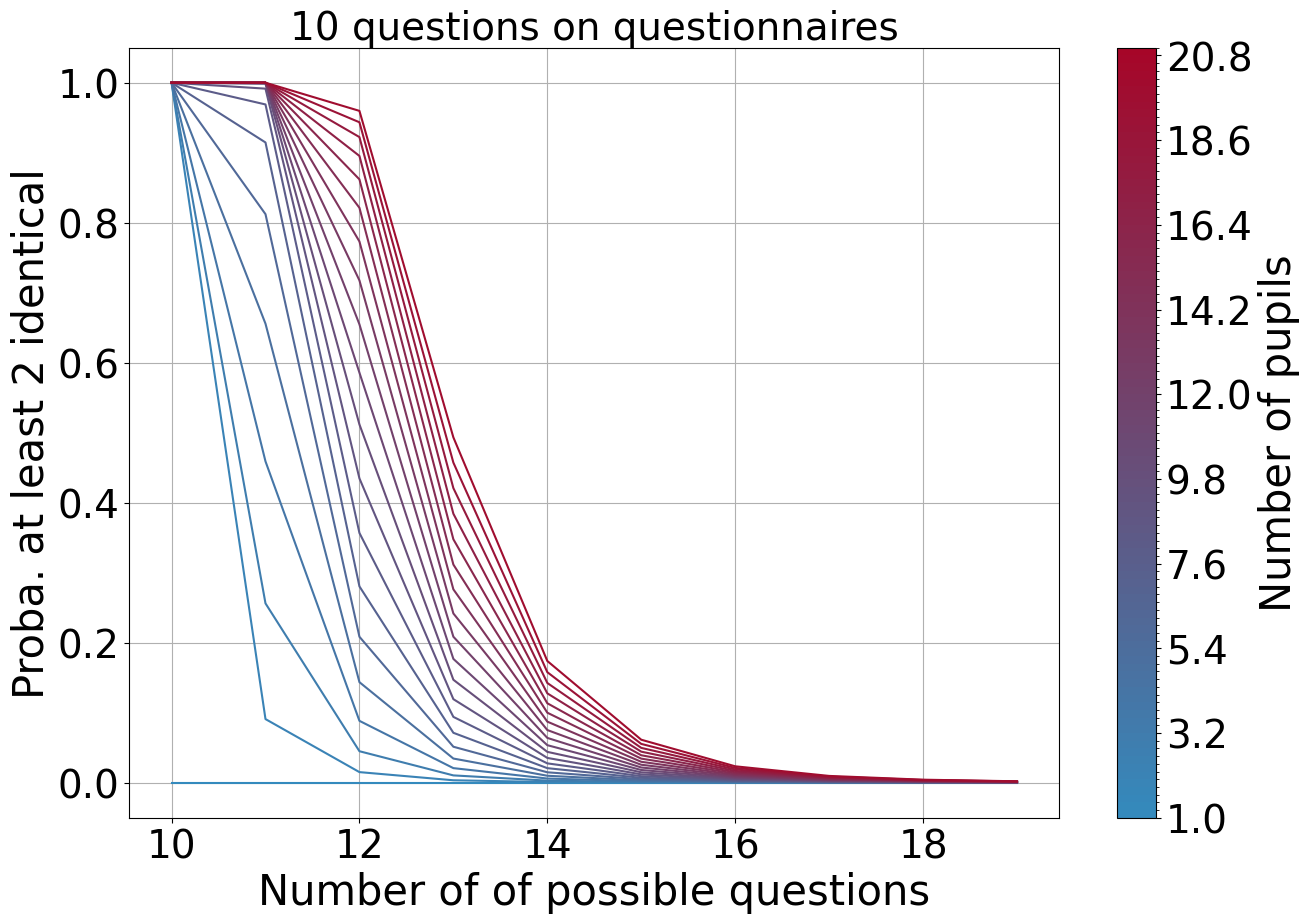

In [249]:
n = 10
N_max = 20
M_min = 1
M_max = 21

xxN = list(range(n, N_max))
xxM = list(range(M_min, M_max))

    
fig, ax = subplots()

cm = simple_color_map_function(nice_colors[0], nice_colors[2], min_value=M_min, max_value=M_max)
sm = simple_colormap_object(cm, min_value=M_min, max_value=M_max, k=100)

for M in xxM:
    
    p_exact_vec = np.vectorize(lambda x: p_exact_fastest(n, x, M))
    results = p_exact_vec(xxN)
    
    ax.plot(xxN, results, '-', lw=1.5, c=cm(M))
    
    ax.set_title('{} questions on questionnaires'.format(n))
    ax.set_xlabel('Number of of possible questions')
    ax.set_ylabel('Proba. at least 2 identical')
    
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_ylabel('Number of pupils')

In [204]:
M = 30 # number of pupils
N = 20
n_max = N  # number of questions

p_exact_vec = np.vectorize(lambda x: p_exact_fastest(x, N, M))
xxn = list(range(1, n_max)) # number of possible questions
results = p_exact_vec(xxn)

Text(0, 0.5, 'Proba. at least 2 identical')

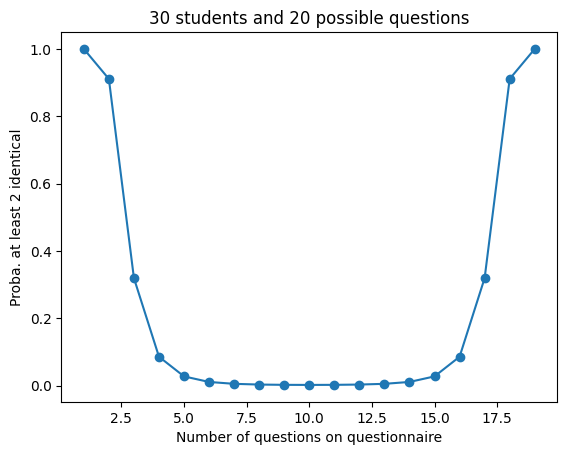

In [205]:
fig, ax = subplots()
ax.plot(xxn, results, 'o-')

ax.set_title('{} students and {} possible questions'.format(M, N))
ax.set_xlabel('Number of questions on questionnaire')
ax.set_ylabel('Proba. at least 2 identical')

Text(0, 0.5, 'Number of pupils')

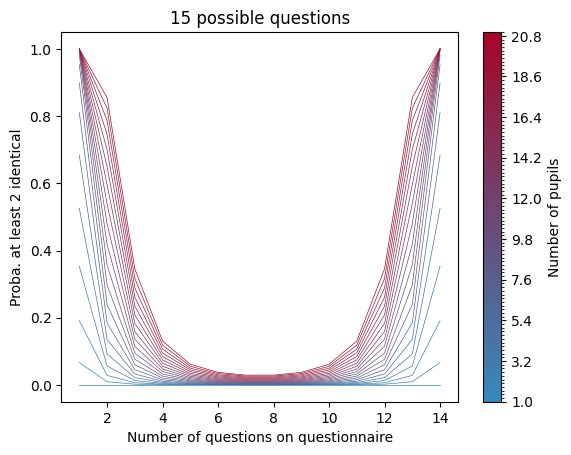

In [235]:
N = 15
n_max = N
    
fig, ax = subplots()

xxn = list(range(1, n_max))

M_min = 1
M_max = 21

xxM = list(range(M_min, M_max))

cm = simple_color_map_function(nice_colors[0], nice_colors[2], min_value=M_min, max_value=M_max)
sm = simple_colormap_object(cm, min_value=M_min, max_value=M_max, k=100)

for M in xxM:
    
    p_exact_vec = np.vectorize(lambda x: p_exact_fastest(x, N, M))
    results = p_exact_vec(xxn)
    
    ax.plot(xxn, results, '-', lw=0.5, c=cm(M))
    
    ax.set_title('{} possible questions'.format(N))
    ax.set_xlabel('Number of questions on questionnaire')
    ax.set_ylabel('Proba. at least 2 identical')
    
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_ylabel('Number of pupils')

# Handy function

In [187]:
# Handy function to choose number of questions you need to avoid two identical questionnaires

def number_of_questions(n, M, p_alpha=0.01):
    """
    Parameters
    ==========
    n: number of questions on a questionnaire
    M: number of pupils
    p_alpha: threshold for the proba of not having two identical questionnaires
    
    Returns
    N: smallest number of questions for which the proba is smaller than p_alpha
    p: the corresponding probability.
    """
    
    N = n
    p = p_exact_fastest(n, N, M)
   
    while p>p_alpha:
        N += 1
        p = p_exact_fastest(n, N, M)
        
    return N, p

(17, 0.00972530932757465)

In [197]:
print (number_of_questions(10, 20))
print (number_of_questions(10, 40))

(17, 0.00972530932757465)
(19, 0.00840921560590191)


# Testing area

In [56]:
# Generate set of copies
def gen_copy_string(questions, n):
    return ''.join(sorted(np.random.choice(questions, size=n, replace=False)))

def gen_copies_string(n, N, M):
    assert N<=26
    questions = list(string.ascii_lowercase)[:N]
    return [gen_copy_string(questions, n) for i in range(M)]

# Sample 
def compute_approximate_proba_string(n_iter, n=7, N=50, M=30):
    results = [is_there_at_least_two_identical_copies(gen_copies_string(n, N, M)) for i in range(n_iter)]
    
    return np.mean(results)
    

In [62]:
N = 4
M = 4
n = 2
n_iter = 10000

t0 = time.time()
compute_approximate_proba(n_iter, n=n, N=N, M=M)
t1 = time.time()
print (t1-t0)

t0 = time.time()
compute_approximate_proba_string(n_iter, n=n, N=N, M=M)
t1 = time.time()
print (t1-t0)

0.8509030342102051
1.0645544528961182


In [63]:
copies = [tuple([1, 2, 0]), tuple([1, 2, 0]), tuple([3, 4, 1])]
#copies = [tuple([1, 2, 0]), tuple([1, 2, 0]), tuple([3, 4, 1]), tuple([3, 4, 1])]
#copies = [tuple([1, 2, 0]), tuple([3, 4, 1])]

set(copies)

{(1, 2, 0), (3, 4, 1)}

In [36]:
is_there_exactly_two_identical_copies(copies)

False

In [19]:
set([1, 2, 0])

{0, 1, 2}

In [24]:
set([1, 2, 0]) == set([2, 0, 1])

True

In [69]:
tuple([1, 2, 0]).__hash__()

-3194506032951434905

In [82]:
df = pd.DataFrame([copy.__hash__() for copy in copies])
df['pouet'] = 1.
counts = df.groupby(0).count()['pouet']
len(counts[counts==2])

1